## 라이브러리 삽입

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product

from xgboost import XGBRegressor
from xgboost import plot_importance

In [47]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')

test = pd.read_csv('test.csv')

In [48]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## 이상치 제거

<AxesSubplot:xlabel='item_price'>

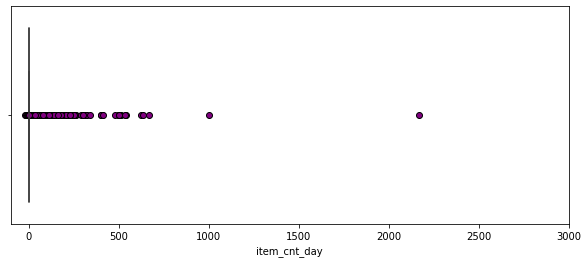

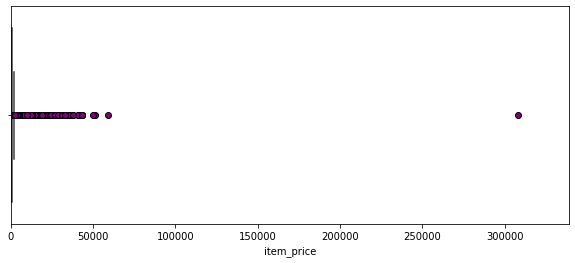

In [49]:
# 출처: Future Sales3
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [50]:
# 판매량과 가격의 이상치를 제거해 준다.
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

## shop 데이터 정리

In [51]:
# shops 이름 정리
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [52]:
# shop city column 추가
from sklearn.preprocessing import LabelEncoder
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_name", "shop_id", "shop_city"]]

## item category 데이터 정리

In [54]:

cats["main_cat_id"] = cats.item_category_name.str.split("-").map( lambda x: x[0] )
cats["main_cat_id"] = LabelEncoder().fit_transform( cats.main_cat_id )
cats = cats[["item_category_name", "item_category_id", "main_cat_id"]]

In [57]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# РостовНаДону ТРК "Мегацентр Горизонт"
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [58]:
cats[0:20]

,item_category_name,item_category_id,main_cat_id
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
5,Аксессуары - PSVita,5,1
6,Аксессуары - XBOX 360,6,1
7,Аксессуары - XBOX ONE,7,1
8,Билеты (Цифра),8,2
9,Доставка товара,9,3


In [69]:
monthly_sales=train.groupby(["date_block_num","shop_id","item_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [75]:
monthly_sales

item_price  item_cnt_day
date_block_num shop_id item_id                          
0              2       27           2499.0           1.0
                       33            499.0           1.0
                       317           299.0           1.0
                       438           299.0           1.0
                       471           399.0           2.0
...                                    ...           ...
33             59      22087         119.0           6.0
                       22088         119.0           2.0
                       22091         179.0           1.0
                       22100         629.0           1.0
                       22102        1250.0           1.0

[1608270 rows x 2 columns]